Import Data
---

In [1]:
import pandas as pd

#df = pd.read_csv("DataBase_Draft_2_18_2020.csv")
df = pd.read_csv("DataBase_Draft_3_23_2020.csv")
df.head()

,ID,GroupNum,Height,Weight,Age,Male,RightLeg,AdaptationDuration,Abrupt,MidSpeed,...,FastBase,MidBase,EarlyA,TMSteady,TMAfter,OGBase,OGAfter,IsCatch,Stroke,TextSpeedRatio
0,B001,1,160.0,60.9,20.0,0,1,604,1,1100,...,NaN,-0.011106,-0.31663,-0.024818,0.34534,-0.159450,-0.159450,1,0,2.0
1,B002,1,183.5,70.5,-1.0,1,1,602,1,1000,...,NaN,0.014585,-0.31588,-0.012164,NaN,-0.042375,-0.042375,1,0,2.0
2,B003,1,174.0,68.0,20.0,0,1,602,1,1100,...,NaN,0.042100,-0.25082,-0.029926,0.13394,0.005824,0.005824,1,0,2.0
3,B004,1,159.0,59.2,20.0,1,1,603,1,1000,...,NaN,0.002496,-0.27043,-0.071999,0.15988,0.057757,0.057757,1,0,2.0
4,BC001,1,160.0,60.9,20.0,0,1,601,1,1100,...,NaN,0.004680,-0.23265,-0.011651,0.12224,-0.029394,-0.029394,1,0,2.0


Data Checking
---

In [2]:
import matplotlib.pyplot as plt  # To visualize
import math #rounding up

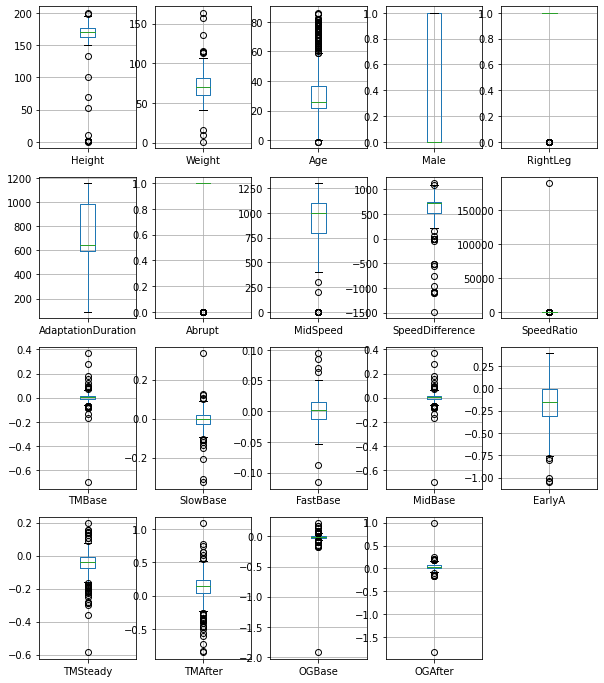

In [3]:
Measures2Check=["Height", "Weight", "Age", "Male", "RightLeg", "AdaptationDuration",\
               "Abrupt", "MidSpeed", "SpeedDifference", "SpeedRatio", \
               "TMBase", "SlowBase", "FastBase", "MidBase", "EarlyA",\
               "TMSteady", "TMAfter", "OGBase", "OGAfter"]


def CheckingBoxWhiskers(Inputs='Height'):
    nrows=math.ceil(len(Inputs)/5)
    plt.figure(figsize=(10, 12))
    for i in range(len(Inputs)):
        plt.subplot(nrows, 5, i+1)
        hist = df.boxplot(column=Inputs[i])
    plt.show()
    
CheckingBoxWhiskers(Measures2Check)  

Data Cleaning
---

We know from previous notebook that there are issues with some of the data.  I am going to create a clean copy of the data file to work with

In [4]:
import pandas as pd
import numpy as np # Data cleaning and manipulaitons

In [5]:
# Make a COPY of my data for cleaning
dfClean=df.copy()

In [6]:
# I don't want to drop all rows with NaNs because there are experiemental reasons why there may be Nans
# So here is a better means to get rid of rows that are missing 'essential' data
badIndex=(np.isnan(df.TMSteady)) | (np.isnan(df.SpeedDifference)) | (np.isnan(df.SpeedRatio)) |\
(np.isnan(df.EarlyA)) | (np.isnan(df.MidBase)) | (np.isnan(df.Age)) |\
(np.isnan(df.AdaptationDuration)) | (abs(df.SpeedRatio)>3) | (df.Age<18) |\
((df.SpeedRatio != 2) & (df.SpeedRatio != 3))

dfClean = dfClean.drop(dfClean[badIndex].index)

dfClean.shape

(467, 26)

Note to self -- Who are these people with missing data, can I recover this data?

In [7]:
#df.loc[badIndex, "ID"]

Due to data collection difference some of these measures may have the wrong "sign" so I will correct that here.

In [8]:
dfClean["SpeedDifference"]=abs(dfClean["SpeedDifference"])
dfClean["SpeedRatio"]=abs(dfClean["SpeedRatio"])
dfClean["MidSpeed"]=abs(dfClean["MidSpeed"])

Some people have the wrong dates/birthdays...

In [9]:
#df.loc[df.Age<18, "ID"]

In [10]:
#df.loc[abs(df.SpeedRatio)>3, "ID"]

In [11]:
#df.loc[abs(df.SpeedRatio)<2, "ID"]

<Figure size 720x864 with 0 Axes>

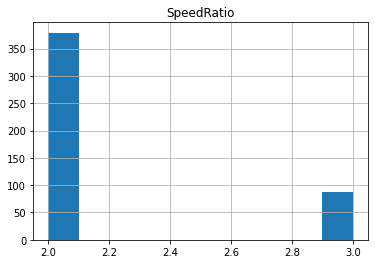

In [12]:
plt.figure(figsize=(10, 12))
dfClean.hist('SpeedRatio')
plt.show()

Feature Engineering:
---
Might consider making some interaction terms at some point?

Make a column with BMI

In [13]:
# Convert Heights in meters to centimeters for consistency
MeterHeight = dfClean.loc[dfClean["Height"]<2,'Height'].index
dfClean.at[MeterHeight,'Height'] = 100 * dfClean.loc[dfClean["Height"]<2, "Height"]

# Calculate what the mean resonable weight is
NormalHeight = dfClean.loc[dfClean["Height"]>122,'Height'].index
NormalHeightMean = dfClean.loc[NormalHeight,'Height'].mean()

# Replace unresonable weights with the mean
WrongHeight = dfClean.loc[dfClean["Height"]<122,'Height'].index
dfClean.at[WrongHeight,'Height'] = NormalHeightMean

dfClean["Height"].describe()

count    467.000000
mean     170.913571
std        8.975599
min      132.500000
25%      164.000000
50%      171.300000
75%      176.900000
max      200.000000
Name: Height, dtype: float64

In [14]:
# Convert confirmed weights in pounds to killograms
dfClean.at[dfClean["ID"]=="CG09_NewProKin", "Weight"]=61.7
dfClean.at[dfClean["ID"]=="Forget17", "Weight"]=71.2

In [15]:
# Finally, calculate BMI
dfClean["BMI"] = (dfClean["Weight"]/(dfClean["Height"]/100)**2)
dfClean.loc[dfClean["BMI"]>40, ["Height", "Weight", "BMI"]]

,Height,Weight,BMI
52,162.2,114.0,43.331443
331,183.5,163.4,48.526606


The BMI is still very high for some of the subjects, but these are consistent with self reported heights and weights.

Feature Engineering: Discretize Age ... Anything Else?
---

In [16]:
dfClean["Young"]=1*(dfClean["Age"]<40)

In [17]:
dfClean["Age"].describe()

count    467.000000
mean      35.363847
std       20.073505
min       18.000000
25%       22.000000
50%       26.000000
75%       38.041650
max       86.000000
Name: Age, dtype: float64

Feature Engineering: Discretize TMSteady States
---

Okay, so Rayid suggested that I discretize the steady states for now to make my interpretation of the ML analysis easier.  Given that we know 0.04 is a clinically signfiicant step length asymmetry threshold and that this roughly corresponds to the 50% percentile of steady states (see below) I am using this a somewhat arbitrary threshold for "good" vs. "bad" steady states.

In other words  I am framining this as a classification problem.  Specifically, I am classifying those that get basically to symmetric stepping or overshot symmetry (which would be energetically optimal, but this level of optimization is usually not possible for the duration of a single session).

In [18]:
dfClean["TMSteady"].describe()

count    467.000000
mean      -0.047885
std        0.068674
min       -0.586560
25%       -0.072465
50%       -0.039097
75%       -0.010512
max        0.158950
Name: TMSteady, dtype: float64

In [19]:
dfClean["TMSteadyGood"]=1*(dfClean["TMSteady"]> -0.04)
import seaborn as sns # Also to visualize
sns.countplot(x="TMSteadyGood", data=dfClean)

In [20]:
dfClean["TMSteadyPositive"]=1*(dfClean["TMSteady"]> 0)

In [21]:
dfClean["TMAfter"].describe()

count    461.000000
mean       0.141015
std        0.196638
min       -0.848090
25%        0.073458
50%        0.155350
75%        0.239870
max        1.081200
Name: TMAfter, dtype: float64

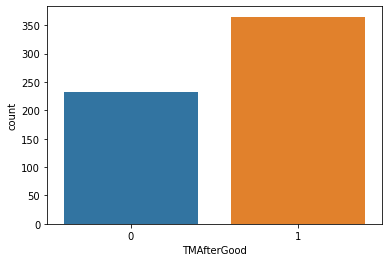

In [24]:
dfClean["TMAfterGood"]=1*(dfClean["TMAfter"]> 0.04)
sns.countplot(x="TMAfterGood", data=dfClean)
plt.show()

There are more people who have a good "TMAfterGood", but it is so unbalanced that I should use over-sampling (i.e., SMOTE -- Synthetic Minority Oversampling Technique)?

Transforming Explortation
---

In [25]:
Measures2Check=["Height", "Weight", "Age", "AdaptationDuration",\
                "MidSpeed", "SpeedDifference", "TMBase", \
                "EarlyA", "BMI"]

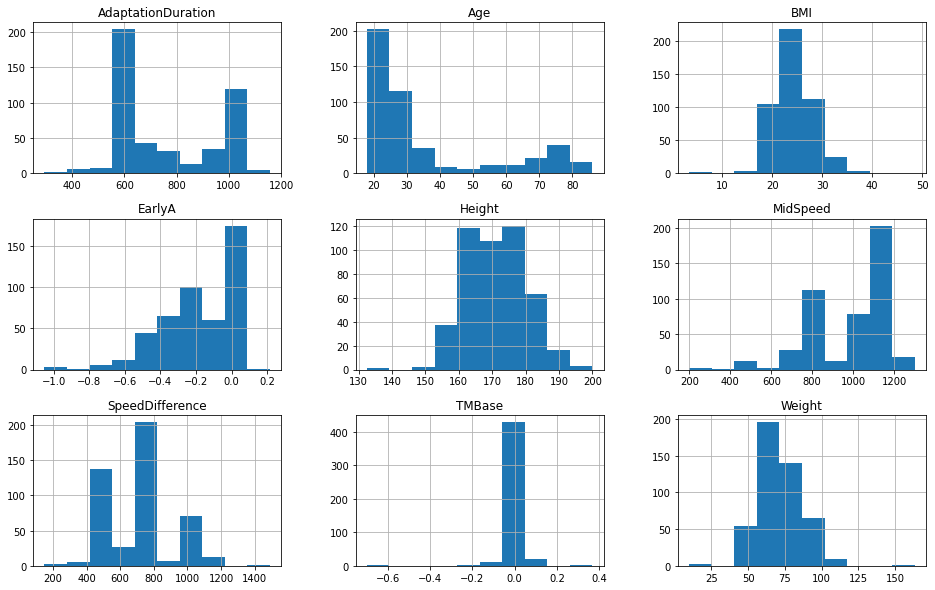

In [26]:
dfClean[Measures2Check].hist(figsize = (16, 10));
plt.show()

There are several features which seem normally distributed:
- BMI
- Height
- Weight
- MidBase/TMbase

There are a few features which are multi-modal and/or skewed:
- Adaptation Duration
- Age
- EarlyA
- MidSpeed
- SpeedDifference


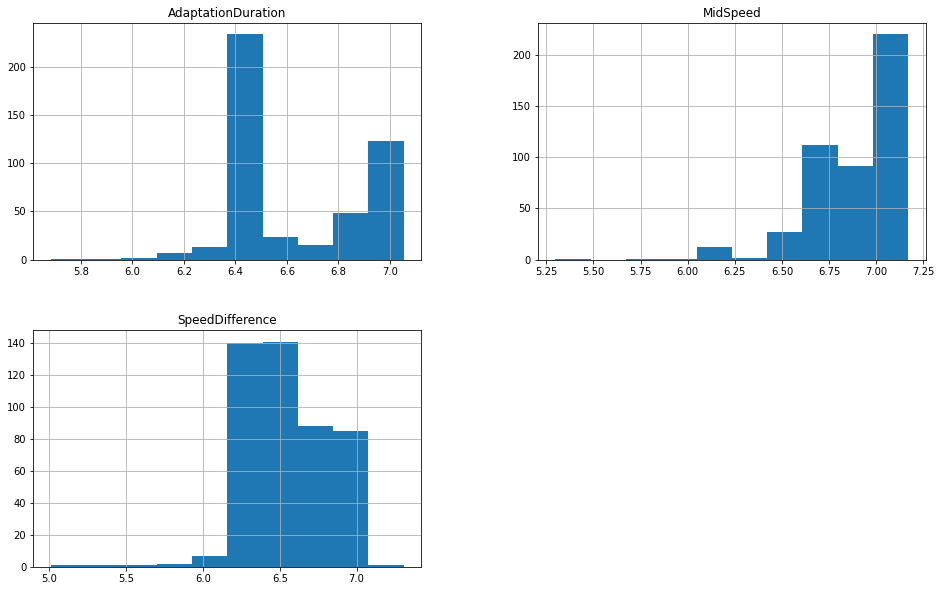

In [27]:
import numpy as np
NotNormalAndPositive=["AdaptationDuration", "MidSpeed", "SpeedDifference"]#,  "MidBase", "EarlyA"
np.log(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10))
#np.sqrt(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10))
#np.cbrt(dfClean[NotNormalAndPositive]).hist(figsize = (16, 10))
plt.show()

These transfromations do not seem particularly beneficial at this time.

Scaling Explortation
---

In [28]:
Measures2Check=["Height", "Weight", "Age", "Male", "RightLeg", "AdaptationDuration",\
                "Abrupt", "MidSpeed", "SpeedDifference", "SpeedRatio", 'IsCatch', 'Stroke',\
                "MidBase", "EarlyA","BMI", "Young", "TMSteadyGood", "TMAfterGood"]

In [29]:
from sklearn import preprocessing


mm_scaler = preprocessing.MinMaxScaler()
dfCleanScaled = pd.DataFrame(mm_scaler.fit_transform(dfClean[Measures2Check]), columns = Measures2Check)

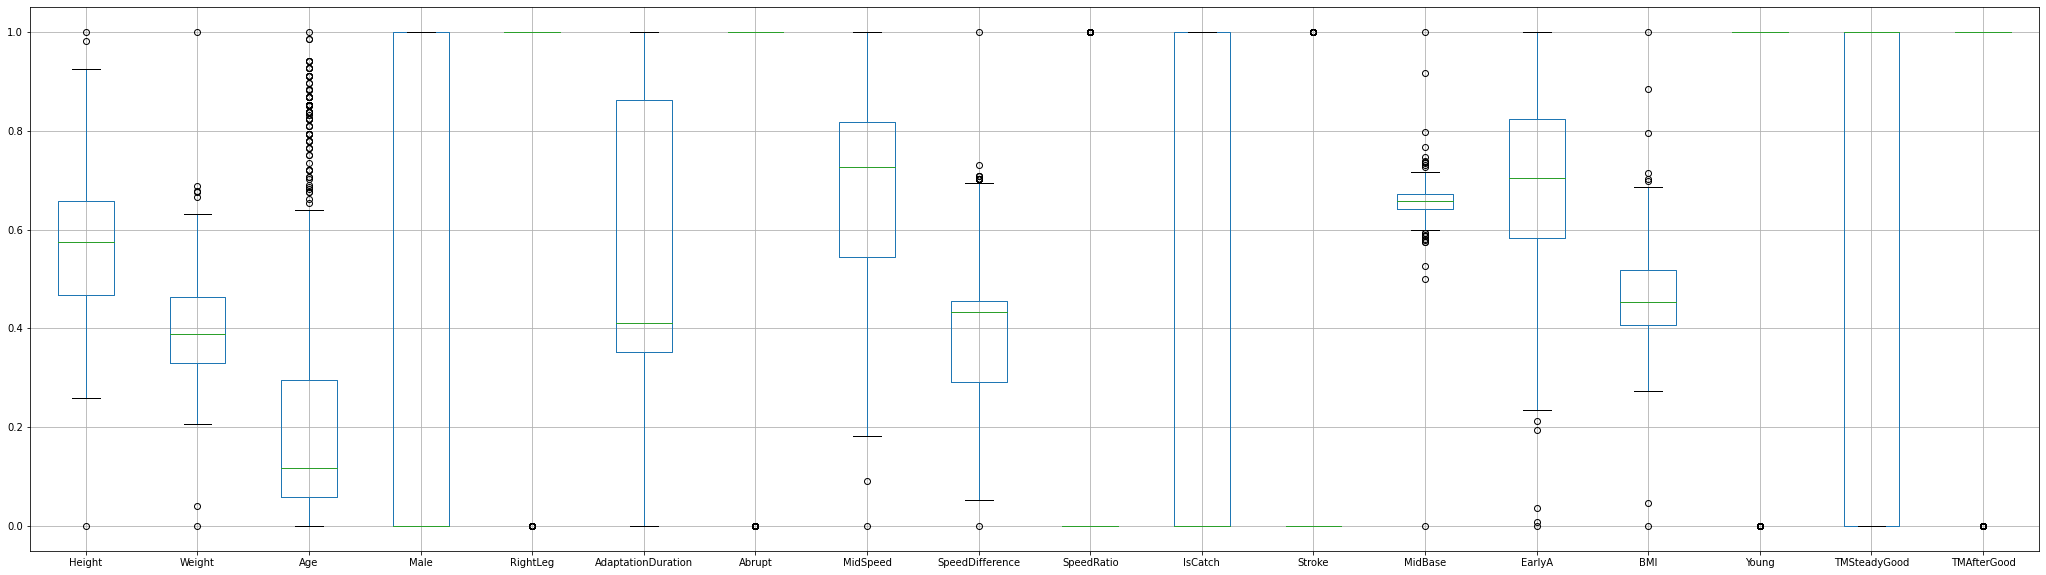

In [30]:
dfCleanScaled[Measures2Check].boxplot(figsize = (36, 10));
plt.show()

Presumably I will want to save the cleaned data....
---

In [29]:
dfClean.to_csv('CleanDataBase.csv', index=False)

In [30]:
dfCleanScaled.to_csv('CleanScaledDataBase.csv', index=False)